In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

2024-04-20 18:53:57.164250: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 18:53:57.167225: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 18:53:57.202889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 18:53:58.557429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("Datasets/cleaned_data.csv")
df.head()

,Type,Branch,Amount,Old Balance Origin,New Balance Origin,Name Destination,Old Balance Destination,New Balance Destination,Unusual Logins,Account Age,Account Type,Time of Day,isFraud
0,PAYMENT,Indonesia,9839.64,170136.0,160296.36,M,0.0,0.0,9,5.895247,Current,Morning,0.0
1,PAYMENT,India,1864.28,21249.0,19384.72,M,0.0,0.0,10,2.705920,Savings,Morning,0.0
2,TRANSFER,India,181.00,181.0,0.00,C,0.0,0.0,2,5.710513,Current,Morning,1.0
3,CASH_OUT,Australia,181.00,181.0,0.00,C,21182.0,0.0,1,6.263347,Current,Afternoon,1.0
4,PAYMENT,Australia,11668.14,41554.0,29885.86,M,0.0,0.0,17,4.632230,Current,Morning,0.0


# Label encoding

In [3]:
df_encoded = df.copy()

In [4]:
encoder = {}
encoded_values = {}
for i in df.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    df_encoded[i] = encoder[i].fit_transform(df[i])

type_mapping = dict(zip(encoder['Type'].classes_, encoder['Type'].transform(encoder['Type'].classes_)))
acctype_mapping = dict(zip(encoder['Account Type'].classes_, encoder['Account Type'].transform(encoder['Account Type'].classes_)))
timeofday_mapping = dict(zip(encoder['Time of Day'].classes_, encoder['Time of Day'].transform(encoder['Time of Day'].classes_)))
branch_mapping = dict(zip(encoder['Branch'].classes_, encoder['Branch'].transform(encoder['Branch'].classes_)))
nameDest_mapping = dict(zip(encoder['Name Destination'].classes_, encoder['Name Destination'].transform(encoder['Name Destination'].classes_)))

print("Encoded values for 'Type' column:", type_mapping)
print("Encoded values for 'Account Type' column:", acctype_mapping)
print("Encoded values for 'Time of Day' column:", timeofday_mapping)
print("Encoded values for 'Branch' column:", branch_mapping)
print("Encoded values for 'Name Destination' column:", nameDest_mapping)

Encoded values for 'Type' column: {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}
Encoded values for 'Account Type' column: {'Current': 0, 'Savings': 1}
Encoded values for 'Time of Day' column: {'Afternoon': 0, 'Morning': 1, 'Night': 2}
Encoded values for 'Branch' column: {'Afganistan': 0, 'Albania': 1, 'Alemania': 2, 'Angola': 3, 'Arabia Saudi': 4, 'Argelia': 5, 'Argentina': 6, 'Australia': 7, 'Austria': 8, 'Azerbaiyan': 9, 'Banglades': 10, 'Barbados': 11, 'Barein': 12, 'Belgica': 13, 'Benin': 14, 'Bielorrusia': 15, 'Bolivia': 16, 'Bosnia y Herzegovina': 17, 'Brasil': 18, 'Bulgaria': 19, 'Burkina Faso': 20, 'Camboya': 21, 'Camerun': 22, 'Canada': 23, 'Chile': 24, 'China': 25, 'Colombia': 26, 'Corea del Sur': 27, 'Costa Rica': 28, 'Costa de Marfil': 29, 'Croacia': 30, 'Cuba': 31, 'Dinamarca': 32, 'Ecuador': 33, 'Egipto': 34, 'El Salvador': 35, 'Emiratos arabes Unidos': 36, 'Eritrea': 37, 'Eslovaquia': 38, 'Espana': 39, 'Estados Unidos': 40, 'Etiopia': 41, 'Filipi

In [5]:
df_encoded.head()

,Type,Branch,Amount,Old Balance Origin,New Balance Origin,Name Destination,Old Balance Destination,New Balance Destination,Unusual Logins,Account Age,Account Type,Time of Day,isFraud
0,3,55,9839.64,170136.0,160296.36,1,0.0,0.0,9,5.895247,0,1,0.0
1,3,54,1864.28,21249.0,19384.72,1,0.0,0.0,10,2.705920,1,1,0.0
2,4,54,181.00,181.0,0.00,0,0.0,0.0,2,5.710513,0,1,1.0
3,1,7,181.00,181.0,0.00,0,21182.0,0.0,1,6.263347,0,0,1.0
4,3,7,11668.14,41554.0,29885.86,1,0.0,0.0,17,4.632230,0,1,0.0


# Correlations

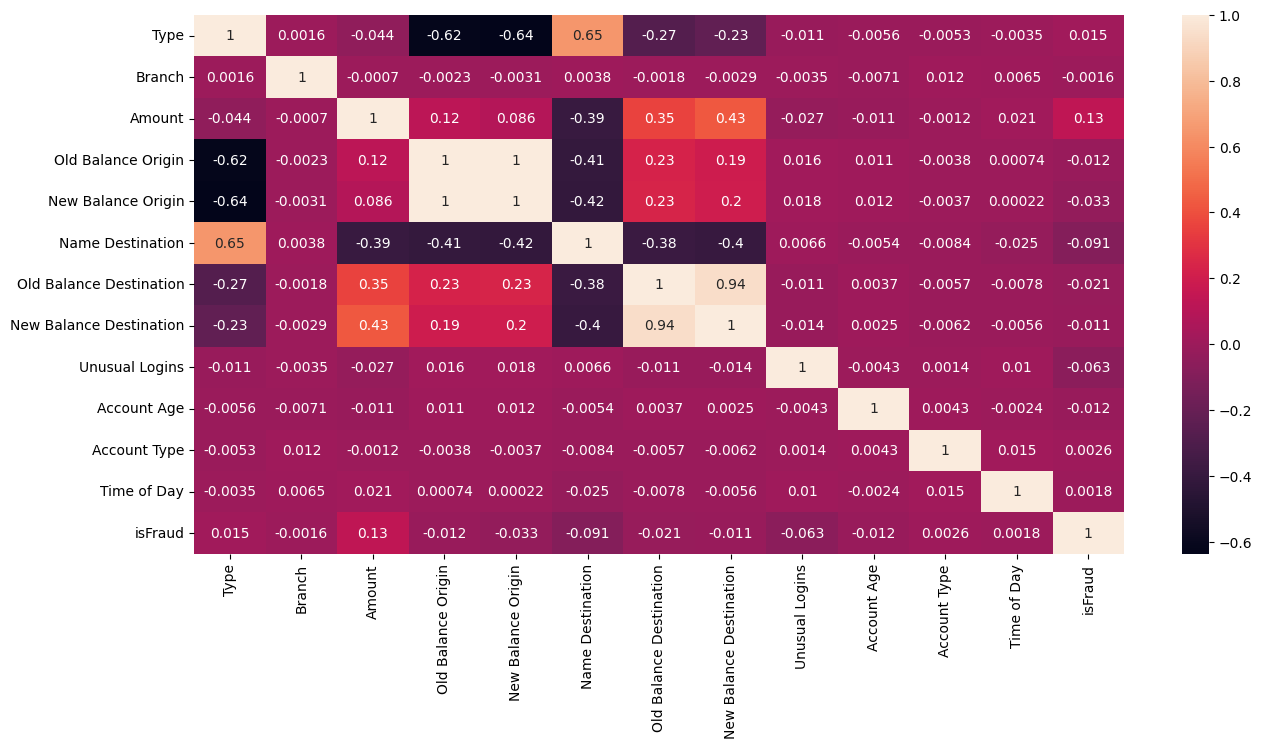

In [6]:
plt.figure(figsize=(15,7))
sns.heatmap(df_encoded.corr(),annot=True)
plt.show()

# Handling Data Imbalance

In [7]:
X = df_encoded.iloc[:,:-1]
y = df_encoded.iloc[:,-1]

In [8]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smoted, y_smoted = smote.fit_resample(X, y)

In [9]:
X_smoted.shape

(20028, 12)

# Testing models

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_smoted, y_smoted, test_size=0.45, random_state=42)

Logistic Regression

In [11]:
logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("Training")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nTesting")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training
Accuracy: 0.9723104857013164
Precision: 0.9631467044649185
Recall: 0.9824688234230978
F1 Score: 0.972711818913841

Testing
Accuracy: 0.9712637301675358
Precision: 0.9621278458844134
Recall: 0.9808078553894221
F1 Score: 0.9713780528235164


Random Forest

In [12]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("Training")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nTesting")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Training
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Testing
Accuracy: 0.9986685898147121
Precision: 0.9979942054825051
Recall: 0.999330506583352
F1 Score: 0.9986619090098127


XGBoost

In [13]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("Training")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nTesting")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Training
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Testing
Accuracy: 0.9978919338732941
Precision: 0.9959982214317474
Recall: 0.999776835527784
F1 Score: 0.9978839514422542


Stratified K fold - Random Forest

In [14]:
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_fold, y_train_fold)

    y_pred = rf_model.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)

    print(f"Fold Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1_score = np.mean(f1_score_list)

print("\nMean Metrics across Folds:")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1-score: {mean_f1_score}")

y_pred_test = rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print("\nTesting Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-score: {f1_test}")

Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.9928057553956835, Recall: 1.0, F1-score: 0.9963898916967509
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 0.9963898916967509, Recall: 1.0, F1-score: 0.9981916817359855
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 0.9964028776978417, Recall: 1.0, F1-score: 0.9981981981981982
Fold Metrics - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-score: 1.0
Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.992831541218638, Recall: 1.0, F1-score: 0.9964028776978417
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 1.0, Recall: 0.9963898916967509, F1-score: 0.9981916817359855
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 0.9964028776978417, Recall: 1.0, F1-score: 0.9981981981981982
Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.992831541218638, Recall: 1.0, F1-score: 0.9964028776978417
Fold Metrics - Accuracy: 0.9945553539019963, Precision: 0.9963768115942029, Recall: 0.9927797833935018,

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Stratified K Fold - XGBoost

In [15]:
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    xgb_classifier_skf = xgb.XGBClassifier()
    xgb_classifier_skf.fit(X_train_fold, y_train_fold)

    y_pred = xgb_classifier_skf.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1)

    print(f"Fold Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

mean_accuracy = np.mean(accuracy_list)
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1_score = np.mean(f1_score_list)

print("\nMean Metrics across Folds:")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1-score: {mean_f1_score}")

y_pred_test = xgb_classifier_skf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print("\nTesting Set Metrics:")
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-score: {f1_test}")

Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.9928057553956835, Recall: 1.0, F1-score: 0.9963898916967509
Fold Metrics - Accuracy: 0.9945553539019963, Precision: 0.989247311827957, Recall: 1.0, F1-score: 0.9945945945945946
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 0.9964028776978417, Recall: 1.0, F1-score: 0.9981981981981982
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 0.9964028776978417, Recall: 1.0, F1-score: 0.9981981981981982
Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.992831541218638, Recall: 1.0, F1-score: 0.9964028776978417
Fold Metrics - Accuracy: 0.9981851179673321, Precision: 1.0, Recall: 0.9963898916967509, F1-score: 0.9981916817359855
Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.992831541218638, Recall: 1.0, F1-score: 0.9964028776978417
Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.992831541218638, Recall: 1.0, F1-score: 0.9964028776978417
Fold Metrics - Accuracy: 0.9963702359346642, Precision: 0.99

Neural Network

In [16]:
y1 = y.reset_index(drop=True)
X1 = X.reset_index(drop=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

i = math.floor(len(X1) * 0.3)
X_train_scaled = X_scaled[:i]
X_test_scaled = X_scaled[i:]
y1_train = y1[:i]
y1_test = y1[i:]

def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X1.shape[1],)),
        Dropout(0.2),  # Dropout layer to prevent overfitting
        BatchNormalization(),  # Batch normalization layer
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []

for train_index, test_index in skf.split(X_train_scaled, y1_train):
    X_train_skf, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_skf, y_val = y1_train[train_index], y1_train[test_index]

    model = create_model()
    model.fit(X_train_skf, y_train_skf, epochs=10, batch_size=32, verbose=0)

    y_pred = (model.predict(X_val) > 0.5).astype("int32")

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

print("Average Accuracy:", np.mean(accuracies))
print("Average Precision:", np.mean(precisions))
print("Average Recall:", np.mean(recalls))

model = create_model()
model.fit(X_train_scaled, y1_train, epochs=10, batch_size=32, verbose=0)
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
test_accuracy = accuracy_score(y1_test, y_test_pred)
test_precision = precision_score(y1_test, y_test_pred)
test_recall = recall_score(y1_test, y_test_pred)

print("\nTest Set Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Average Accuracy: 0.9947107293510807
Average Precision: 0.0
Average Recall: 0.0


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Test Set Metrics:
Accuracy: 0.9926324737886086
Precision: 0.0
Recall: 0.0


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Saving the model

In [19]:
import pickle
path = "prediction_model.pkl"
with open(path, 'wb') as f:
    pickle.dump(rf_classifier,f)